# Starbucks Capstone Challenge

## Project Overview

Periodically Starbucks will send different offers that might be advertisement, discount or buy one get one free (BOGO) to different customers, and not all users receive the same offers. The business question people most interested in is: which groups of people are most responsive to each type of offer (BOGO, Discount, Informational) sent out by Starbucks? If this is predictable, Starbucks could just send the offer to people who are most likely to reponse to save resources. 

In this capstone project, I am using the data simulating customer behavior in the Starbucks reward mobile app, provided by Udacity as part of the Data Scientist Nanodegree to answer the above business question.

## Project Statement / Metrics

## Data Exploration

In [70]:
# import necessary packages for data understanding
import pandas as pd
import numpy as np
import math
import json
%matplotlib inline
import warnings
warnings.filterwarnings("ignore")

In [2]:
# read in the portfolio json files
portfolio = pd.read_json('portfolio.json', orient='records', lines=True)

Data Schema
#### portfolio.json

* id (string) - offer id
* offer_type (string) - type of offer ie BOGO, discount, informational
* difficulty (int) - minimum required spend to complete an offer
* reward (int) - reward given for completing an offer
* duration (int)
* channels (list of strings)

In [4]:
portfolio.head()

,channels,difficulty,duration,id,offer_type,reward
0,"[email, mobile, social]",10,7,ae264e3637204a6fb9bb56bc8210ddfd,bogo,10
1,"[web, email, mobile, social]",10,5,4d5c57ea9a6940dd891ad53e9dbe8da0,bogo,10
2,"[web, email, mobile]",0,4,3f207df678b143eea3cee63160fa8bed,informational,0
3,"[web, email, mobile]",5,7,9b98b8c7a33c4b65b9aebfe6a799e6d9,bogo,5
4,"[web, email]",20,10,0b1e1539f2cc45b7b9fa7c272da2e1d7,discount,5


In [5]:
#check for null values
portfolio.isnull().sum()

channels      0
difficulty    0
duration      0
id            0
offer_type    0
reward        0
dtype: int64

There is no missing value for portfolio data

In [6]:
#check number of unique offers
portfolio['id'].nunique()

10

In [7]:
portfolio.groupby('offer_type')['id'].count()

offer_type
bogo             4
discount         4
informational    2
Name: id, dtype: int64

There are 10 offers, 4 of them are BOGO, 4 of them are Discount and 2 of them are informational

In [8]:
# read in customer demographic info json files
profile = pd.read_json('profile.json', orient='records', lines=True)

Data Schema
#### profile.json

* age (int) - age of the customer
* became_member_on (int) - date when customer created an app account
* gender (str) - gender of the customer (note some entries contain 'O' for other rather than M or F)
* id (str) - customer id
* income (float) - customer's income

In [9]:
profile.head()

,age,became_member_on,gender,id,income
0,118,20170212,None,68be06ca386d4c31939f3a4f0e3dd783,NaN
1,55,20170715,F,0610b486422d4921ae7d2bf64640c50b,112000.0
2,118,20180712,None,38fe809add3b4fcf9315a9694bb96ff5,NaN
3,75,20170509,F,78afa995795e4d85b5d9ceeca43f5fef,100000.0
4,118,20170804,None,a03223e636434f42ac4c3df47e8bac43,NaN


In [16]:
#check for null values
profile.isnull().mean()

age                 0.000000
became_member_on    0.000000
gender              0.127941
id                  0.000000
income              0.127941
dtype: float64

In [11]:
profile['income'][profile['gender'].isnull()].unique()

array([nan])

In [12]:
profile['gender'][profile['income'].isnull()].unique()

array([None], dtype=object)

In [13]:
profile['age'][profile['income'].isnull()].unique()

array([118], dtype=int64)

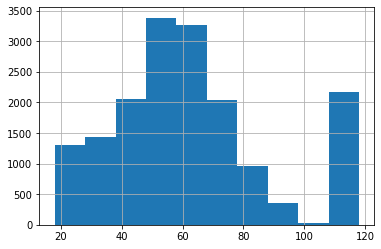

In [14]:
#check distribution of age column
profile['age'].hist()

when gender (income) info is missing, income (gender) info is missing, and age is assigned as 118, we might remove this part of data from our analysis as they do not take a large portion of the data

In [17]:
#check how many distinct people are in dataset
profile['id'].nunique()

17000

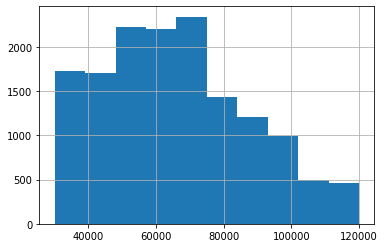

In [18]:
#check distributions of income
profile.income.hist()

In [28]:
profile['gender'].unique()

array([None, 'F', 'M', 'O'], dtype=object)

In [35]:
profile[profile['gender']=='O']['gender'].count()/profile['gender'].count()

0.014300168634064081

A small portion of customer does not have valid gender info, might remove them from analysis

In [36]:
# read in transaction info json files
transcript = pd.read_json('transcript.json', orient='records', lines=True)

Data Schema
#### transcript.json

* event (str) - record description (ie transaction, offer received, offer viewed, etc.)
* person (str) - customer id
* time (int) - time in hours. The data begins at time t=0
* value - (dict of strings) - either an offer id or transaction amount depending on the record

In [20]:
transcript.head()

,event,person,time,value
0,offer received,78afa995795e4d85b5d9ceeca43f5fef,0,{'offer id': '9b98b8c7a33c4b65b9aebfe6a799e6d9'}
1,offer received,a03223e636434f42ac4c3df47e8bac43,0,{'offer id': '0b1e1539f2cc45b7b9fa7c272da2e1d7'}
2,offer received,e2127556f4f64592b11af22de27a7932,0,{'offer id': '2906b810c7d4411798c6938adc9daaa5'}
3,offer received,8ec6ce2a7e7949b1bf142def7d0e0586,0,{'offer id': 'fafdcd668e3743c1bb461111dcafc2a4'}
4,offer received,68617ca6246f4fbc85e91a2a49552598,0,{'offer id': '4d5c57ea9a6940dd891ad53e9dbe8da0'}


In [21]:
transcript['event'].unique()

array(['offer received', 'offer viewed', 'transaction', 'offer completed'],
      dtype=object)

There are four types of event, offer received, viewed, transction and completed, ordered by time

In [22]:
#check for null values
transcript.isnull().sum()

event     0
person    0
time      0
value     0
dtype: int64

In [23]:
#check number of distinct people having transaction info
transcript['person'].nunique()

17000

The number of people in the transaction dataset is consistent with the number of people in the demographic profile

In order to extract insights from the value column, will expand it based on the event type

In [37]:
transcript=pd.concat([transcript, transcript['value'].apply(pd.Series)], axis=1)
transcript.head()

,event,person,time,value,offer id,amount,offer_id,reward
0,offer received,78afa995795e4d85b5d9ceeca43f5fef,0,{'offer id': '9b98b8c7a33c4b65b9aebfe6a799e6d9'},9b98b8c7a33c4b65b9aebfe6a799e6d9,NaN,NaN,NaN
1,offer received,a03223e636434f42ac4c3df47e8bac43,0,{'offer id': '0b1e1539f2cc45b7b9fa7c272da2e1d7'},0b1e1539f2cc45b7b9fa7c272da2e1d7,NaN,NaN,NaN
2,offer received,e2127556f4f64592b11af22de27a7932,0,{'offer id': '2906b810c7d4411798c6938adc9daaa5'},2906b810c7d4411798c6938adc9daaa5,NaN,NaN,NaN
3,offer received,8ec6ce2a7e7949b1bf142def7d0e0586,0,{'offer id': 'fafdcd668e3743c1bb461111dcafc2a4'},fafdcd668e3743c1bb461111dcafc2a4,NaN,NaN,NaN
4,offer received,68617ca6246f4fbc85e91a2a49552598,0,{'offer id': '4d5c57ea9a6940dd891ad53e9dbe8da0'},4d5c57ea9a6940dd891ad53e9dbe8da0,NaN,NaN,NaN


offer id column is duplicated, clean up the dataset to make offer id unique

In [38]:
transcript['offer_id_2']=np.where(transcript['offer id'].isnull() & transcript['offer_id'].notnull(),transcript['offer_id'],transcript['offer id'])
transcript.drop(['offer id','offer_id'],axis=1,inplace=True)
transcript.rename(columns={'offer_id_2':'offer_id'},inplace=True)

In [39]:
transcript.head()

,event,person,time,value,amount,reward,offer_id
0,offer received,78afa995795e4d85b5d9ceeca43f5fef,0,{'offer id': '9b98b8c7a33c4b65b9aebfe6a799e6d9'},NaN,NaN,9b98b8c7a33c4b65b9aebfe6a799e6d9
1,offer received,a03223e636434f42ac4c3df47e8bac43,0,{'offer id': '0b1e1539f2cc45b7b9fa7c272da2e1d7'},NaN,NaN,0b1e1539f2cc45b7b9fa7c272da2e1d7
2,offer received,e2127556f4f64592b11af22de27a7932,0,{'offer id': '2906b810c7d4411798c6938adc9daaa5'},NaN,NaN,2906b810c7d4411798c6938adc9daaa5
3,offer received,8ec6ce2a7e7949b1bf142def7d0e0586,0,{'offer id': 'fafdcd668e3743c1bb461111dcafc2a4'},NaN,NaN,fafdcd668e3743c1bb461111dcafc2a4
4,offer received,68617ca6246f4fbc85e91a2a49552598,0,{'offer id': '4d5c57ea9a6940dd891ad53e9dbe8da0'},NaN,NaN,4d5c57ea9a6940dd891ad53e9dbe8da0


## Data Processing

#### First, I would like to explore what kind of event are available for each offer type

In [40]:
#rename IDs in the profile and portfolio table so that the names are consistent across three tables
profile.rename(columns={'id':'person'},inplace=True)
portfolio.rename(columns={'id':'offer_id'},inplace=True)

In [45]:
transcript.merge(portfolio,how='left',on='offer_id').groupby(['event','offer_type'])['offer_type'].count()

event            offer_type   
offer completed  bogo             15669
                 discount         17910
offer received   bogo             30499
                 discount         30543
                 informational    15235
offer viewed     bogo             25449
                 discount         21445
                 informational    10831
Name: offer_type, dtype: int64

#### Second, I would like to define effective offer for each offer type

There are four types of events, offer received, viewed, completed and transaction, transaction does not have any offer id attached with it.
BOGO and Discount offer have offer completed, but infomational offer does not have offer completed

For BOGO and Discount offer, an effective offer would be identified if the following events happening in the right order like:
offer received -> offer viewed -> transaction -> offer completed (between offer recived and expired) 

For informational offer, an effective offer would be identified if the following events happening in the righ order like:
offer received -> offer viewed -> transaction (between offer recived and expired)

#### Lastly I would like to do feature engineer to extract the features that would be used for modeling

In [47]:
# extract the channel info for each offer type
def email(x):
    if 'email' in x:
        return 1
    else:
        return 0
portfolio['email']=portfolio['channels'].apply(lambda x:email(x))

def web(x):
    if 'web' in x:
        return 1
    else:
        return 0
portfolio['web']=portfolio['channels'].apply(lambda x:web(x))

def mobile(x):
    if 'mobile' in x:
        return 1
    else:
        return 0
portfolio['mobile']=portfolio['channels'].apply(lambda x:mobile(x))

def social(x):
    if 'social' in x:
        return 1
    else:
        return 0
portfolio['social']=portfolio['channels'].apply(lambda x:social(x))

In [48]:
#calculate the offer count for each person by offer id, this will be one of the potential features for modeling
offercount=transcript[transcript['event']=='offer received'].groupby(['person','offer_id']).count()['time'].reset_index().rename(columns={'time':'offercount'})

In [50]:
#merge three datasets together
df=transcript.merge(profile,how='left',on=['person'])
df=df.merge(offercount,how='left',on=['person','offer_id'])
offersAll=df.merge(portfolio,how='left',on=['offer_id'])
offersAll.drop(['reward_x'],inplace=True,axis=1)
offersAll.rename(columns={'reward_y':'reward'},inplace=True)
offersAll.drop(['channels','value','amount'],inplace=True,axis=1)
offersAll.head()

,event,person,time,offer_id,age,became_member_on,gender,income,offercount,difficulty,duration,offer_type,reward,email,web,mobile,social
0,offer received,78afa995795e4d85b5d9ceeca43f5fef,0,9b98b8c7a33c4b65b9aebfe6a799e6d9,75,20170509,F,100000.0,1.0,5.0,7.0,bogo,5.0,1.0,1.0,1.0,0.0
1,offer received,a03223e636434f42ac4c3df47e8bac43,0,0b1e1539f2cc45b7b9fa7c272da2e1d7,118,20170804,None,NaN,3.0,20.0,10.0,discount,5.0,1.0,1.0,0.0,0.0
2,offer received,e2127556f4f64592b11af22de27a7932,0,2906b810c7d4411798c6938adc9daaa5,68,20180426,M,70000.0,1.0,10.0,7.0,discount,2.0,1.0,1.0,1.0,0.0
3,offer received,8ec6ce2a7e7949b1bf142def7d0e0586,0,fafdcd668e3743c1bb461111dcafc2a4,118,20170925,None,NaN,2.0,10.0,10.0,discount,2.0,1.0,1.0,1.0,1.0
4,offer received,68617ca6246f4fbc85e91a2a49552598,0,4d5c57ea9a6940dd891ad53e9dbe8da0,118,20171002,None,NaN,1.0,10.0,5.0,bogo,10.0,1.0,1.0,1.0,1.0


Convert become_member_on to a feature indicating the tenure of membership, this is a potential feature affecting whether people taking the offer

In [51]:
offersAll['became_member_on'].max()

20180726

The lastest becoming member date is 20180726, we assume all data collected on 20180727, it does not matter the data was collected on 20180727 or not, as we will do feature normalization before modeling

In [52]:
from datetime import datetime
def diffDays(x):
    d1 = datetime(2018,7,27)
    d2=datetime(year=int(str(x)[0:4]), month=int(str(x)[4:6]), day=int(str(x)[6:8]))
    return abs(d1-d2).days
offersAll['became_member_days']=offersAll['became_member_on'].apply(lambda x: diffDays(x))

In [110]:
#pull event offer received info, only considering people with valid gender
offer_receive=offersAll[offersAll['event']=='offer received'][['person','age','gender','became_member_days','income','offer_id','time','offer_type','duration','difficulty','reward','web','email','mobile','social','offercount']]
offer_receive=offer_receive[offer_receive['gender'].isin(['F','M'])]
offer_receive['expiration']=offer_receive['duration']*24+offer_receive['time']

In [54]:
#pull event offer viewed info
offer_view=offersAll[offersAll['event']=='offer viewed'][['person','age','gender','became_member_days','income','offer_id','time','offer_type','duration','difficulty','reward','web','email','mobile','social','offercount']]

In [56]:
#pull event offer completed info
offer_complete=offersAll[offersAll['event']=='offer completed'][['person','age','gender','became_member_days','income','offer_id','time','offer_type','duration','difficulty','reward','web','email','mobile','social','offercount']]

In [58]:
#pull event transaction info
transaction=offersAll[['person','time']][offersAll['event']=='transaction']

Identify all effective offers

In [61]:
#Idenfity BOGO and Discount effective offers
offer_recview=offer_receive.merge(offer_view,how='left',on=['person','offer_id'])[['person','age_x','gender_x','became_member_days_x','income_x','offer_id','offer_type_x','duration_x','difficulty_x','reward_x','web_x','email_x','mobile_x','social_x','time_x','expiration','time_y','offercount_x']]
offer_recviecom=offer_recview.merge(offer_complete,how='left',on=['person','offer_id'])[['person','age_x','gender_x','became_member_days_x','income_x','offer_id','offer_type_x','duration_x','difficulty_x','reward_x','web_x','email_x','mobile_x','social_x','time_x','expiration','time_y','time','offercount_x']]
offer_respond=offer_recviecom[(offer_recviecom['time_x']<=offer_recviecom['time_y'])&(offer_recviecom['time_y']<=offer_recviecom['time'])&(offer_recviecom['time']<=offer_recviecom['expiration'])]
offer_respond.head()

,person,age_x,gender_x,became_member_days_x,income_x,offer_id,offer_type_x,duration_x,difficulty_x,reward_x,web_x,email_x,mobile_x,social_x,time_x,expiration,time_y,time,offercount_x
0,78afa995795e4d85b5d9ceeca43f5fef,75,F,444,100000.0,9b98b8c7a33c4b65b9aebfe6a799e6d9,bogo,7.0,5.0,5.0,1.0,1.0,1.0,0.0,0,168.0,6.0,132.0,1.0
2,389bc3fa690240e798340f5a15918d5c,65,M,168,53000.0,f19421c1d4aa40978ebb69ca19b0e20d,bogo,5.0,5.0,5.0,1.0,1.0,1.0,1.0,0,120.0,0.0,60.0,2.0
13,d53717f5400c4e84affdaeda9dd926b3,88,F,435,53000.0,0b1e1539f2cc45b7b9fa7c272da2e1d7,discount,10.0,20.0,5.0,1.0,1.0,0.0,0.0,0,240.0,30.0,30.0,2.0
17,f806632c011441378d4646567f357a21,42,M,1811,69000.0,fafdcd668e3743c1bb461111dcafc2a4,discount,10.0,10.0,2.0,1.0,1.0,1.0,1.0,0,240.0,18.0,126.0,2.0
21,d058f73bf8674a26a95227db098147b1,56,F,90,88000.0,0b1e1539f2cc45b7b9fa7c272da2e1d7,discount,10.0,20.0,5.0,1.0,1.0,0.0,0.0,0,240.0,30.0,192.0,2.0


In [62]:
#Identify Informational effective offers
offer_receive_info=offer_receive[offer_receive['offer_type']=='informational']
transaction_info=offer_receive_info.merge(transaction,how='left',on=['person'])
infoffer_res=transaction_info[(transaction_info['time_x']<=transaction_info['time_y'])&(transaction_info['time_y']<=transaction_info['expiration'])]
infoffer_res.head()

,person,age,gender,became_member_days,income,offer_id,time_x,offer_type,duration,difficulty,reward,web,email,mobile,social,offercount,expiration,time_y
4,c27e0d6ab72c455a8bb66d980963de60,78,F,406,71000.0,3f207df678b143eea3cee63160fa8bed,0,informational,4.0,0.0,0.0,1.0,1.0,1.0,0.0,2.0,96.0,18.0
5,c27e0d6ab72c455a8bb66d980963de60,78,F,406,71000.0,3f207df678b143eea3cee63160fa8bed,0,informational,4.0,0.0,0.0,1.0,1.0,1.0,0.0,2.0,96.0,72.0
12,be8a5d1981a2458d90b255ddc7e0d174,39,M,1522,51000.0,5a8bc65990b245e5a138643cd4eb9837,0,informational,3.0,0.0,0.0,0.0,1.0,1.0,1.0,1.0,72.0,6.0
13,be8a5d1981a2458d90b255ddc7e0d174,39,M,1522,51000.0,5a8bc65990b245e5a138643cd4eb9837,0,informational,3.0,0.0,0.0,0.0,1.0,1.0,1.0,1.0,72.0,24.0
14,be8a5d1981a2458d90b255ddc7e0d174,39,M,1522,51000.0,5a8bc65990b245e5a138643cd4eb9837,0,informational,3.0,0.0,0.0,0.0,1.0,1.0,1.0,1.0,72.0,30.0


In [145]:
# Extract feaure values for people responsive to the BOGO offer
Res_Bogo=offer_respond[offer_respond['offer_type_x']=='bogo'][['age_x','gender_x','income_x','person','became_member_days_x','offercount_x','duration_x','difficulty_x','reward_x','web_x','email_x','mobile_x','social_x','offer_type_x']]
Res_Bogo['response']=1

In [146]:
# Extract feaure values for people responsive to the Discount offer
Res_discount=offer_respond[offer_respond['offer_type_x']=='discount'][['age_x','gender_x','income_x','person','became_member_days_x','offercount_x','duration_x','difficulty_x','reward_x','web_x','email_x','mobile_x','social_x','offer_type_x']]
Res_discount['response']=1

In [147]:
# Extract feaure values for people responsive to the Informational offer
Res_info=infoffer_res[['age','gender','income','person','became_member_days','offercount','duration','difficulty','reward','web','email','mobile','social','offer_type']]
Res_info['response']=1

A person could receive the same type of offer several times, if the person takes the offer once, we would assume this person is responsive to the offer type

In [149]:
# Extract feaure values for people not responsive to BOGO offer
Res_Bogo_PersID=offer_respond[offer_respond['offer_type_x']=='bogo']['person'].tolist()
NonRes_Bogo=offer_receive[~offer_receive['person'].isin(Res_Bogo_PersID)][offer_receive['offer_type']=='bogo'][['age','gender','income','person','became_member_days','offercount','duration','difficulty','reward','web','email','mobile','social','offer_type']]
NonRes_Bogo['response']=0

In [150]:
# Extract feaure values for people not responsive to Discount offer
Res_discount_PersID=offer_respond[offer_respond['offer_type_x']=='discount']['person'].tolist()
NonRes_discount=offer_receive[~offer_receive['person'].isin(Res_discount_PersID)][offer_receive['offer_type']=='discount'][['age','gender','income','person','became_member_days','offercount','duration','difficulty','reward','web','email','mobile','social','offer_type']]
NonRes_discount['response']=0

In [151]:
# Extract feaure values for people not responsive to Informational offer
Res_info_PersID=infoffer_res['person'].tolist()
NonRes_info=offer_receive_info[~offer_receive_info['person'].isin(Res_info_PersID)][['age','gender','income','person','became_member_days','offercount','duration','difficulty','reward','web','email','mobile','social','offer_type']]
NonRes_info['response']=0

In [152]:
#rename feature names for BOGO and Discount 
Res_Bogo.rename(columns={'age_x':'age','gender_x':'gender','income_x':'income','became_member_days_x':'became_member_days','offercount_x':'offercount','duration_x':'duration','difficulty_x':'difficulty','reward_x':'reward','web_x':'web','email_x':'email','mobile_x':'mobile','social_x':'social','offer_type_x':'offer_type'},inplace=True)
Res_discount.rename(columns={'age_x':'age','gender_x':'gender','income_x':'income','became_member_days_x':'became_member_days','offercount_x':'offercount','duration_x':'duration','difficulty_x':'difficulty','reward_x':'reward','web_x':'web','email_x':'email','mobile_x':'mobile','social_x':'social','offer_type_x':'offer_type'},inplace=True)

In [153]:
#drop duplicates for Bogo Offer
Res_Bogo.drop_duplicates(keep='first',inplace=True)
NonRes_Bogo.drop_duplicates(keep='first',inplace=True)

In [154]:
#drop duplicates for Discount Offer
Res_discount.drop_duplicates(keep='first',inplace=True)
NonRes_discount.drop_duplicates(keep='first',inplace=True)

In [155]:
#drop duplicates for Informational Offer
Res_info.drop_duplicates(keep='first',inplace=True)
NonRes_info.drop_duplicates(keep='first',inplace=True)

In [156]:
#check the responsive and non-responsive data size for BOGO offer, to see if there is imbalanced data issue
Res_Bogo.shape

(9473, 15)

In [157]:
NonRes_Bogo.shape

(8867, 15)

In [158]:
#check the responsive and non-responsive data size for discount offer, to see if there is imbalanced data issue
Res_discount.shape

(10365, 15)

In [159]:
NonRes_discount.shape

(7351, 15)

In [160]:
#check the responsive and non-responsive data size for Informational offer, to see if there is imbalanced data issue
Res_info.shape

(7299, 15)

In [161]:
NonRes_info.shape

(2876, 15)

There is no imbalance data issue for all three types

In [162]:
#Concat nonresponsive and responsive data together for BOGO offer
Matrix_AllBogo=pd.concat([Res_Bogo,NonRes_Bogo])
Matrix_AllBogo['social'].mean()
Matrix_AllBogo['web'].mean()
Matrix_AllBogo['mobile'].mean()
#channel email is always 1 for BOGO offer, need remove it from analysis as it does not provide any distinguishing information
Matrix_AllBogo['email'].mean()

1.0

In [163]:
Matrix_Alldiscount=pd.concat([Res_discount,NonRes_discount])
Matrix_Alldiscount['mobile'].mean()
Matrix_Alldiscount['social'].mean()
Matrix_Alldiscount['web'].mean()
#channel email is always 1 for Discount offer, need remove it from analysis as it does not provide any distinguishing information
Matrix_Alldiscount['email'].mean()

1.0

In [164]:
Matrix_Allinfo=pd.concat([Res_info,NonRes_info])
Matrix_Allinfo['social'].mean()
Matrix_Allinfo['web'].mean()
#channel email and mobile is always 1 for Informational offer, need remove it from analysis as it does not provide any distinguishing information
Matrix_Allinfo['mobile'].mean()
Matrix_Allinfo['email'].mean()

1.0

In [165]:
#generate dummy variable for gender, and remove channel email for BOGO offer
gender_DummyBogo=pd.get_dummies(Matrix_AllBogo['gender'],drop_first=True).rename(columns={'M':'genderM'})
Matrix_AllBogo=pd.concat([Matrix_AllBogo.drop(['email'],axis=1),gender_DummyBogo],axis=1)
del Matrix_AllBogo['gender']

In [166]:
#generate dummy variable for gender, and remove channel email for Discount offer
gender_Dummydiscount=pd.get_dummies(Matrix_Alldiscount['gender'],drop_first=True).rename(columns={'M':'genderM'})
Matrix_Alldiscount=pd.concat([Matrix_Alldiscount.drop(['email'],axis=1),gender_Dummydiscount],axis=1)
del Matrix_Alldiscount['gender']

In [167]:
#generate dummy variable for gender, and remove channel email for informational offer
gender_Dummyinfo=pd.get_dummies(Matrix_Allinfo['gender'],drop_first=True).rename(columns={'M':'genderM'})
Matrix_Allinfo=pd.concat([Matrix_Allinfo.drop(['email','mobile'],axis=1),gender_Dummyinfo],axis=1)
del Matrix_Allinfo['gender']

## Implementation

#### Modeling for BOGO offer

In [344]:
X=Matrix_AllBogo[['age','genderM','income','became_member_days','offercount','duration','difficulty','reward','social','web','mobile']]
Y=Matrix_AllBogo[['response']]

In [345]:
X.head()

,age,genderM,income,became_member_days,offercount,duration,difficulty,reward,social,web,mobile
0,75,0,100000.0,444,1.0,7.0,5.0,5.0,0.0,1.0,1.0
2,65,1,53000.0,168,2.0,5.0,5.0,5.0,1.0,1.0,1.0
29,69,0,57000.0,712,1.0,5.0,10.0,10.0,1.0,1.0,1.0
31,75,1,40000.0,988,1.0,5.0,5.0,5.0,1.0,1.0,1.0
33,45,1,33000.0,20,1.0,7.0,5.0,5.0,0.0,1.0,1.0


The scale for features are different, need to make the scale to be the same as we are going to try some algos that is sensitive to scale, for example KNN

In [346]:
from sklearn.preprocessing import MinMaxScaler
transformer=MinMaxScaler().fit(Matrix_AllBogo[['age','income','response','genderM','became_member_days','offercount','duration','difficulty','reward','social','mobile','web']])
Norm_AllBogo=pd.DataFrame(transformer.transform(Matrix_AllBogo[['age','income','response','genderM','became_member_days','offercount','duration','difficulty','reward','social','mobile','web']]),columns=[['age','income','response','genderM','became_member_days','offercount','duration','difficulty','reward','social','mobile','web']])

In [347]:
#make the responsive variable as int
Norm_AllBogo['response']=Norm_AllBogo['response'].astype(int)

In [397]:
X=Norm_AllBogo[['age','genderM','income','became_member_days','offercount','duration','difficulty','reward','social','mobile','web']]
Y=Norm_AllBogo[['response']]

In [349]:
#import libraries for the modeling
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import classification_report
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import f1_score
from sklearn.metrics import make_scorer
from sklearn.metrics import roc_curve,auc
import xgboost as xgb
from xgboost import XGBClassifier

In [398]:
#split the data into training and testing data
x_train,x_test,y_train,y_test=train_test_split(X,Y,test_size=0.25)

Text(0, 0.5, 'Accuracy')

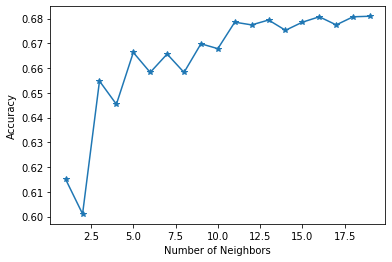

In [399]:
#first try KNN
import matplotlib.pyplot as plt
accuracy=[]
for i in range(1,20):
    knn=KNeighborsClassifier(n_neighbors=i)
    knn.fit(x_train,y_train)
    report = classification_report(y_test['response'],knn.predict(x_test), output_dict=True )
    accuracy.append(report['accuracy'])
plt.plot(range(1,20),accuracy,marker='*')
plt.xlabel('Number of Neighbors')
plt.ylabel('Accuracy')

In [400]:
# N=13 is the best number for N
knn=KNeighborsClassifier(n_neighbors=13)
knn.fit(x_train,y_train)
print(classification_report(y_test['response'],knn.predict(x_test)))
print(confusion_matrix(y_test['response'],knn.predict(x_test)))

              precision    recall  f1-score   support

           0       0.66      0.67      0.66      2179
           1       0.70      0.69      0.69      2406

    accuracy                           0.68      4585
   macro avg       0.68      0.68      0.68      4585
weighted avg       0.68      0.68      0.68      4585

[[1450  729]
 [ 741 1665]]


In [401]:
#try random forest
clf=RandomForestClassifier()
clf.fit(x_train,y_train)
print(classification_report(y_test['response'],clf.predict(x_test)))

              precision    recall  f1-score   support

           0       0.63      0.70      0.66      2179
           1       0.70      0.62      0.66      2406

    accuracy                           0.66      4585
   macro avg       0.66      0.66      0.66      4585
weighted avg       0.66      0.66      0.66      4585



In [402]:
#try XGboosting
xbg=XGBClassifier()
xbg.fit(x_train,y_train)
print(classification_report(y_test['response'],xbg.predict(x_test)))

              precision    recall  f1-score   support

           0       0.70      0.72      0.71      2179
           1       0.74      0.73      0.73      2406

    accuracy                           0.72      4585
   macro avg       0.72      0.72      0.72      4585
weighted avg       0.72      0.72      0.72      4585



* Model ranking based on accurary:
    1. XG Boosting accuracy is 0.72
    2. KNN accuracy is 0.66
    3. Random Forest accuracy is 0.68
* Results sugguest XG Boosting is the best model among the three, based on accuray 

#### Refinement for BOGO model

In [403]:
#Refine XG boosting using GridCV
parameter={'n_estimators':[300,1000,500],'max_depth':[3,6,10,15],'min_samples_split':[3,6,8,10]}
#f1_scorer=make_scorer(f1_score,average='macro',pos_label=0)
#cv=GridSearchCV(xbg,parameter,scoring=f1_scorer)
cv=GridSearchCV(xbg,parameter)
cv.fit(x_train,y_train)

[22:30:44] WARNING: C:\Users\Administrator\workspace\xgboost-win64_release_1.1.0\src\learner.cc:480: 
Parameters: { min_samples_split } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[22:30:44] WARNING: C:\Users\Administrator\workspace\xgboost-win64_release_1.1.0\src\learner.cc:480: 
Parameters: { min_samples_split } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[22:30:45] WARNING: C:\Users\Administrator\workspace\xgboost-win64_release_1.1.0\src\learner.cc:480: 
Parameters: { min_samples_split } might not be used.

  This may not be accurate due to some parameters are 

[22:31:17] WARNING: C:\Users\Administrator\workspace\xgboost-win64_release_1.1.0\src\learner.cc:480: 
Parameters: { min_samples_split } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[22:31:20] WARNING: C:\Users\Administrator\workspace\xgboost-win64_release_1.1.0\src\learner.cc:480: 
Parameters: { min_samples_split } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[22:31:23] WARNING: C:\Users\Administrator\workspace\xgboost-win64_release_1.1.0\src\learner.cc:480: 
Parameters: { min_samples_split } might not be used.

  This may not be accurate due to some parameters are 

[22:32:07] WARNING: C:\Users\Administrator\workspace\xgboost-win64_release_1.1.0\src\learner.cc:480: 
Parameters: { min_samples_split } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[22:32:10] WARNING: C:\Users\Administrator\workspace\xgboost-win64_release_1.1.0\src\learner.cc:480: 
Parameters: { min_samples_split } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[22:32:13] WARNING: C:\Users\Administrator\workspace\xgboost-win64_release_1.1.0\src\learner.cc:480: 
Parameters: { min_samples_split } might not be used.

  This may not be accurate due to some parameters are 

[22:33:13] WARNING: C:\Users\Administrator\workspace\xgboost-win64_release_1.1.0\src\learner.cc:480: 
Parameters: { min_samples_split } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[22:33:15] WARNING: C:\Users\Administrator\workspace\xgboost-win64_release_1.1.0\src\learner.cc:480: 
Parameters: { min_samples_split } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[22:33:16] WARNING: C:\Users\Administrator\workspace\xgboost-win64_release_1.1.0\src\learner.cc:480: 
Parameters: { min_samples_split } might not be used.

  This may not be accurate due to some parameters are 

[22:34:30] WARNING: C:\Users\Administrator\workspace\xgboost-win64_release_1.1.0\src\learner.cc:480: 
Parameters: { min_samples_split } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[22:34:39] WARNING: C:\Users\Administrator\workspace\xgboost-win64_release_1.1.0\src\learner.cc:480: 
Parameters: { min_samples_split } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[22:34:46] WARNING: C:\Users\Administrator\workspace\xgboost-win64_release_1.1.0\src\learner.cc:480: 
Parameters: { min_samples_split } might not be used.

  This may not be accurate due to some parameters are 

[22:36:20] WARNING: C:\Users\Administrator\workspace\xgboost-win64_release_1.1.0\src\learner.cc:480: 
Parameters: { min_samples_split } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[22:36:23] WARNING: C:\Users\Administrator\workspace\xgboost-win64_release_1.1.0\src\learner.cc:480: 
Parameters: { min_samples_split } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[22:36:27] WARNING: C:\Users\Administrator\workspace\xgboost-win64_release_1.1.0\src\learner.cc:480: 
Parameters: { min_samples_split } might not be used.

  This may not be accurate due to some parameters are 

[22:38:29] WARNING: C:\Users\Administrator\workspace\xgboost-win64_release_1.1.0\src\learner.cc:480: 
Parameters: { min_samples_split } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[22:38:32] WARNING: C:\Users\Administrator\workspace\xgboost-win64_release_1.1.0\src\learner.cc:480: 
Parameters: { min_samples_split } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[22:38:35] WARNING: C:\Users\Administrator\workspace\xgboost-win64_release_1.1.0\src\learner.cc:480: 
Parameters: { min_samples_split } might not be used.

  This may not be accurate due to some parameters are 

GridSearchCV(cv='warn', error_score='raise-deprecating',
             estimator=XGBClassifier(base_score=0.5, booster='gbtree',
                                     colsample_bylevel=1, colsample_bynode=1,
                                     colsample_bytree=1, gamma=0, gpu_id=-1,
                                     importance_type='gain',
                                     interaction_constraints='',
                                     learning_rate=0.300000012,
                                     max_delta_step=0, max_depth=6,
                                     min_child_weight=1, missing=nan,
                                     monotone_constraints='()',
                                     n...
                                     objective='binary:logistic',
                                     random_state=0, reg_alpha=0, reg_lambda=1,
                                     scale_pos_weight=1, subsample=1,
                                     tree_method='exact', validate_

In [404]:
print(classification_report(y_test['response'],cv.predict(x_test)))

              precision    recall  f1-score   support

           0       0.72      0.74      0.73      2179
           1       0.76      0.74      0.75      2406

    accuracy                           0.74      4585
   macro avg       0.74      0.74      0.74      4585
weighted avg       0.74      0.74      0.74      4585



After refinement the accuracy and f1 score in testing dataset are 0.72

In [359]:
cv.best_params_

{'max_depth': 6, 'min_samples_split': 3, 'n_estimators': 300}

In [361]:
#final BOGO Model hyperparameter values
cv.best_estimator_

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
              importance_type='gain', interaction_constraints='',
              learning_rate=0.300000012, max_delta_step=0, max_depth=6,
              min_child_weight=1, min_samples_split=3, missing=nan,
              monotone_constraints='()', n_estimators=300, n_jobs=0,
              num_parallel_tree=1, objective='binary:logistic', random_state=0,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, subsample=1,
              tree_method='exact', validate_parameters=1, verbosity=None)

[22:02:40] WARNING: C:\Users\Administrator\workspace\xgboost-win64_release_1.1.0\src\learner.cc:480: 
Parameters: { min_samples_split } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.




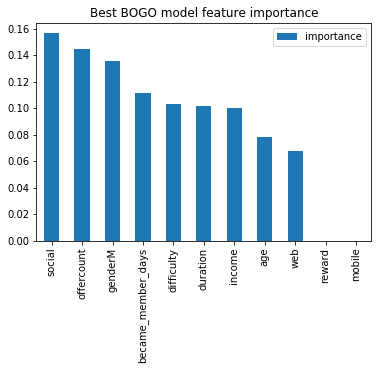

In [362]:
model=XGBClassifier(max_depth=6,min_samples_split=3,n_estimators=300)
model.fit(x_train,y_train)
feature_importances = pd.DataFrame(model.feature_importances_,
                                   index = ['age','genderM','income','became_member_days','offercount','duration','difficulty','reward','social','mobile','web'],
                                    columns=['importance']).sort_values('importance',ascending=False)
feature_importances.plot.bar()
plt.title('Best BOGO model feature importance')
plt.show()

* Results shows feature importance ranking for BOGO model:
    1. whether the BOGO offer is broadcasted by social media
    2. the number of offer the customer received
    3. the gender of the customer
    4. how long the customer has been Starbucks members
    5. offer difficulty
    6. offer duration
    7. the income of the customer
    8. age of customer
    9. whether the BOGO offer is broadcasted in web
    

#### Modeling for Discount Offer

In [363]:
X=Matrix_Alldiscount[['age','genderM','income','became_member_days','offercount','duration','difficulty','reward','social','mobile','web']]
Y=Matrix_Alldiscount[['response']]
transformer=MinMaxScaler().fit(Matrix_Alldiscount[['age','income','response','genderM','became_member_days','offercount','duration','difficulty','reward','social','mobile','web']])
Norm_Alldiscount=pd.DataFrame(transformer.transform(Matrix_Alldiscount[['age','income','response','genderM','became_member_days','offercount','duration','difficulty','reward','social','mobile','web']]),columns=[['age','income','response','genderM','became_member_days','offercount','duration','difficulty','reward','social','mobile','web']])

In [364]:
Norm_Alldiscount['response']=Norm_Alldiscount['response'].astype(int)
X=Norm_Alldiscount[['age','genderM','income','became_member_days','offercount','duration','difficulty','reward','social','mobile','web']]
Y=Norm_Alldiscount[['response']]

Text(0, 0.5, 'Accuracy')

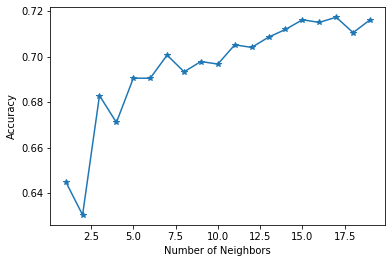

In [365]:
x_train,x_test,y_train,y_test=train_test_split(X,Y,test_size=0.2)
#first try KNN
import matplotlib.pyplot as plt
accuracy=[]
for i in range(1,20):
    knn=KNeighborsClassifier(n_neighbors=i)
    knn.fit(x_train,y_train)
    report = classification_report(y_test['response'],knn.predict(x_test), output_dict=True )
    accuracy.append(report['accuracy'])
plt.plot(range(1,20),accuracy,marker='*')
plt.xlabel('Number of Neighbors')
plt.ylabel('Accuracy')

In [366]:
# N=17 is the best number for N
knn=KNeighborsClassifier(n_neighbors=17)
knn.fit(x_train,y_train)
print(classification_report(y_test['response'],knn.predict(x_test)))
print(confusion_matrix(y_test['response'],knn.predict(x_test)))

              precision    recall  f1-score   support

           0       0.68      0.62      0.65      1495
           1       0.74      0.79      0.76      2049

    accuracy                           0.72      3544
   macro avg       0.71      0.70      0.71      3544
weighted avg       0.72      0.72      0.72      3544

[[ 933  562]
 [ 440 1609]]


In [367]:
#try random forest
clf=RandomForestClassifier()
clf.fit(x_train,y_train)
print(classification_report(y_test['response'],clf.predict(x_test)))

              precision    recall  f1-score   support

           0       0.63      0.66      0.65      1495
           1       0.75      0.72      0.73      2049

    accuracy                           0.69      3544
   macro avg       0.69      0.69      0.69      3544
weighted avg       0.70      0.69      0.70      3544



In [368]:
#try XGboosting
xbg=XGBClassifier()
xbg.fit(x_train,y_train)
print(classification_report(y_test['response'],xbg.predict(x_test)))

              precision    recall  f1-score   support

           0       0.71      0.65      0.68      1495
           1       0.76      0.80      0.78      2049

    accuracy                           0.74      3544
   macro avg       0.73      0.73      0.73      3544
weighted avg       0.74      0.74      0.74      3544



* Model ranking based on accurary:
    1. XG Boosting accuracy is 0.74
    2. KNN accuracy is 0.72
    3. Random Forest accuracy is 0.69
* Results sugguest XG Boosting is the best model among the three, based on accuray

#### Refinement for Discount model

In [369]:
#Refine XG boosting using GridCV
parameter={'n_estimators':[300,1000,500],'max_depth':[3,6,10,15],'min_samples_split':[3,6,8,10]}
f1_scorer=make_scorer(f1_score,average='macro',pos_label=0)
cv=GridSearchCV(xbg,parameter,scoring=f1_scorer)
cv.fit(x_train,y_train)

[22:05:10] WARNING: C:\Users\Administrator\workspace\xgboost-win64_release_1.1.0\src\learner.cc:480: 
Parameters: { min_samples_split } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[22:05:11] WARNING: C:\Users\Administrator\workspace\xgboost-win64_release_1.1.0\src\learner.cc:480: 
Parameters: { min_samples_split } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[22:05:12] WARNING: C:\Users\Administrator\workspace\xgboost-win64_release_1.1.0\src\learner.cc:480: 
Parameters: { min_samples_split } might not be used.

  This may not be accurate due to some parameters are 

[22:05:42] WARNING: C:\Users\Administrator\workspace\xgboost-win64_release_1.1.0\src\learner.cc:480: 
Parameters: { min_samples_split } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[22:05:45] WARNING: C:\Users\Administrator\workspace\xgboost-win64_release_1.1.0\src\learner.cc:480: 
Parameters: { min_samples_split } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[22:05:48] WARNING: C:\Users\Administrator\workspace\xgboost-win64_release_1.1.0\src\learner.cc:480: 
Parameters: { min_samples_split } might not be used.

  This may not be accurate due to some parameters are 

[22:06:32] WARNING: C:\Users\Administrator\workspace\xgboost-win64_release_1.1.0\src\learner.cc:480: 
Parameters: { min_samples_split } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[22:06:34] WARNING: C:\Users\Administrator\workspace\xgboost-win64_release_1.1.0\src\learner.cc:480: 
Parameters: { min_samples_split } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[22:06:37] WARNING: C:\Users\Administrator\workspace\xgboost-win64_release_1.1.0\src\learner.cc:480: 
Parameters: { min_samples_split } might not be used.

  This may not be accurate due to some parameters are 

[22:07:32] WARNING: C:\Users\Administrator\workspace\xgboost-win64_release_1.1.0\src\learner.cc:480: 
Parameters: { min_samples_split } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[22:07:34] WARNING: C:\Users\Administrator\workspace\xgboost-win64_release_1.1.0\src\learner.cc:480: 
Parameters: { min_samples_split } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[22:07:35] WARNING: C:\Users\Administrator\workspace\xgboost-win64_release_1.1.0\src\learner.cc:480: 
Parameters: { min_samples_split } might not be used.

  This may not be accurate due to some parameters are 

[22:08:49] WARNING: C:\Users\Administrator\workspace\xgboost-win64_release_1.1.0\src\learner.cc:480: 
Parameters: { min_samples_split } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[22:08:56] WARNING: C:\Users\Administrator\workspace\xgboost-win64_release_1.1.0\src\learner.cc:480: 
Parameters: { min_samples_split } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[22:09:04] WARNING: C:\Users\Administrator\workspace\xgboost-win64_release_1.1.0\src\learner.cc:480: 
Parameters: { min_samples_split } might not be used.

  This may not be accurate due to some parameters are 

[22:10:36] WARNING: C:\Users\Administrator\workspace\xgboost-win64_release_1.1.0\src\learner.cc:480: 
Parameters: { min_samples_split } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[22:10:41] WARNING: C:\Users\Administrator\workspace\xgboost-win64_release_1.1.0\src\learner.cc:480: 
Parameters: { min_samples_split } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[22:10:44] WARNING: C:\Users\Administrator\workspace\xgboost-win64_release_1.1.0\src\learner.cc:480: 
Parameters: { min_samples_split } might not be used.

  This may not be accurate due to some parameters are 

[22:12:48] WARNING: C:\Users\Administrator\workspace\xgboost-win64_release_1.1.0\src\learner.cc:480: 
Parameters: { min_samples_split } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[22:12:51] WARNING: C:\Users\Administrator\workspace\xgboost-win64_release_1.1.0\src\learner.cc:480: 
Parameters: { min_samples_split } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[22:12:54] WARNING: C:\Users\Administrator\workspace\xgboost-win64_release_1.1.0\src\learner.cc:480: 
Parameters: { min_samples_split } might not be used.

  This may not be accurate due to some parameters are 

GridSearchCV(cv='warn', error_score='raise-deprecating',
             estimator=XGBClassifier(base_score=0.5, booster='gbtree',
                                     colsample_bylevel=1, colsample_bynode=1,
                                     colsample_bytree=1, gamma=0, gpu_id=-1,
                                     importance_type='gain',
                                     interaction_constraints='',
                                     learning_rate=0.300000012,
                                     max_delta_step=0, max_depth=6,
                                     min_child_weight=1, missing=nan,
                                     monotone_constraints='()',
                                     n...
                                     random_state=0, reg_alpha=0, reg_lambda=1,
                                     scale_pos_weight=1, subsample=1,
                                     tree_method='exact', validate_parameters=1,
                                     verbosity=None)

In [370]:
print(classification_report(y_test['response'],cv.predict(x_test)))

              precision    recall  f1-score   support

           0       0.72      0.66      0.69      1495
           1       0.77      0.81      0.79      2049

    accuracy                           0.75      3544
   macro avg       0.74      0.74      0.74      3544
weighted avg       0.75      0.75      0.75      3544



After refinement the accuracy is 0.75 and f1 score is 0.75 on testing dataset

In [373]:
#best Discount model hyperparameter values
cv.best_estimator_

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
              importance_type='gain', interaction_constraints='',
              learning_rate=0.300000012, max_delta_step=0, max_depth=6,
              min_child_weight=1, min_samples_split=3, missing=nan,
              monotone_constraints='()', n_estimators=300, n_jobs=0,
              num_parallel_tree=1, objective='binary:logistic', random_state=0,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, subsample=1,
              tree_method='exact', validate_parameters=1, verbosity=None)

In [374]:
cv.best_params_

{'max_depth': 6, 'min_samples_split': 3, 'n_estimators': 300}

[22:16:24] WARNING: C:\Users\Administrator\workspace\xgboost-win64_release_1.1.0\src\learner.cc:480: 
Parameters: { min_samples_split } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.




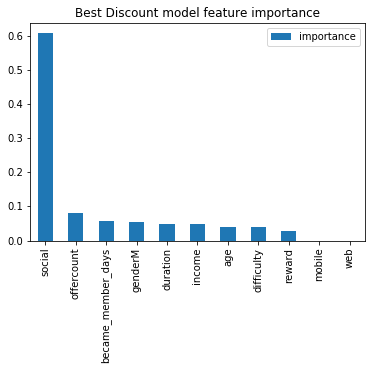

In [375]:
model=XGBClassifier(max_depth=6,min_samples_split=3,n_estimators=300)
model.fit(x_train,y_train)
feature_importances = pd.DataFrame(model.feature_importances_,
                                   index = ['age','genderM','income','became_member_days','offercount','duration','difficulty','reward','social','mobile','web'],
                                    columns=['importance']).sort_values('importance',ascending=False)
feature_importances.plot.bar()
plt.title('Best Discount model feature importance')
plt.show()

* Results shows feature importance ranking for Discoun model:
    1. whether the discount offer is broadcasted by social media
    2. the number of offer the customer received
    3. how long the customer has been Starbucks members
    4. the gender of the customer
    5. offer duration
    6. the income of the customer
    7. age of customer
    8. offer difficulty
    9. offer reward

#### Modeling for Informational  Offer

In [413]:
X=Matrix_Allinfo[['age','genderM','income','became_member_days','offercount','duration','difficulty','reward','social','web']]
Y=Matrix_Allinfo[['response']]
transformer=MinMaxScaler().fit(Matrix_Allinfo[['age','income','response','genderM','became_member_days','offercount','duration','difficulty','reward','social','web']])
Norm_Allinfo=pd.DataFrame(transformer.transform(Matrix_Allinfo[['age','income','response','genderM','became_member_days','offercount','duration','difficulty','reward','social','web']]),columns=[['age','income','response','genderM','became_member_days','offercount','duration','difficulty','reward','social','web']])

In [414]:
Norm_Allinfo['response']=Norm_AllBogo['response'].astype(int)
X=Norm_Allinfo[['age','genderM','income','became_member_days','offercount','duration','difficulty','reward','social','web']]
Y=Norm_Allinfo[['response']]

Text(0, 0.5, 'Accuracy')

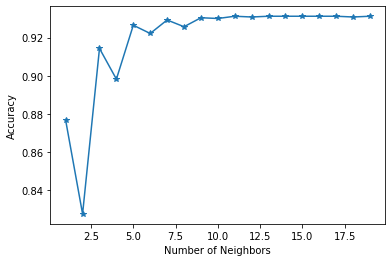

In [418]:
x_train,x_test,y_train,y_test=train_test_split(X,Y,test_size=0.25)
#first try KNN
import matplotlib.pyplot as plt
accuracy=[]
for i in range(1,20):
    knn=KNeighborsClassifier(n_neighbors=i)
    knn.fit(x_train,y_train)
    report = classification_report(y_test['response'],knn.predict(x_test), output_dict=True )
    accuracy.append(report['accuracy'])
plt.plot(range(1,20),accuracy,marker='*')
plt.xlabel('Number of Neighbors')
plt.ylabel('Accuracy')

In [419]:
# N=9 is the best number for N
knn=KNeighborsClassifier(n_neighbors=9)
knn.fit(x_train,y_train)
print(classification_report(y_test['response'],knn.predict(x_test)))
print(confusion_matrix(y_test['response'],knn.predict(x_test)))

              precision    recall  f1-score   support

           0       0.00      0.00      0.00       175
           1       0.93      1.00      0.96      2369

    accuracy                           0.93      2544
   macro avg       0.47      0.50      0.48      2544
weighted avg       0.87      0.93      0.90      2544

[[   0  175]
 [   2 2367]]


In [420]:
#try random forest
clf=RandomForestClassifier()
clf.fit(x_train,y_train)
print(classification_report(y_test['response'],clf.predict(x_test)))

              precision    recall  f1-score   support

           0       0.12      0.03      0.05       175
           1       0.93      0.98      0.96      2369

    accuracy                           0.92      2544
   macro avg       0.53      0.51      0.50      2544
weighted avg       0.88      0.92      0.89      2544



In [421]:
#try XGboosting
xbg=XGBClassifier()
xbg.fit(x_train,y_train)
print(classification_report(y_test['response'],xbg.predict(x_test)))

              precision    recall  f1-score   support

           0       0.22      0.02      0.04       175
           1       0.93      0.99      0.96      2369

    accuracy                           0.93      2544
   macro avg       0.58      0.51      0.50      2544
weighted avg       0.88      0.93      0.90      2544



#### Refinement for Informational offer

In [422]:
#Refine XG boosting using GridCV
parameter={'n_estimators':[300,1000,500],'max_depth':[3,6,10,15],'min_samples_split':[3,6,8,10]}
cv=GridSearchCV(xbg,parameter)
cv.fit(x_train,y_train)

[12:02:01] WARNING: C:\Users\Administrator\workspace\xgboost-win64_release_1.1.0\src\learner.cc:480: 
Parameters: { min_samples_split } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[12:02:02] WARNING: C:\Users\Administrator\workspace\xgboost-win64_release_1.1.0\src\learner.cc:480: 
Parameters: { min_samples_split } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[12:02:02] WARNING: C:\Users\Administrator\workspace\xgboost-win64_release_1.1.0\src\learner.cc:480: 
Parameters: { min_samples_split } might not be used.

  This may not be accurate due to some parameters are 

[12:02:21] WARNING: C:\Users\Administrator\workspace\xgboost-win64_release_1.1.0\src\learner.cc:480: 
Parameters: { min_samples_split } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[12:02:22] WARNING: C:\Users\Administrator\workspace\xgboost-win64_release_1.1.0\src\learner.cc:480: 
Parameters: { min_samples_split } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[12:02:24] WARNING: C:\Users\Administrator\workspace\xgboost-win64_release_1.1.0\src\learner.cc:480: 
Parameters: { min_samples_split } might not be used.

  This may not be accurate due to some parameters are 

[12:02:50] WARNING: C:\Users\Administrator\workspace\xgboost-win64_release_1.1.0\src\learner.cc:480: 
Parameters: { min_samples_split } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[12:02:51] WARNING: C:\Users\Administrator\workspace\xgboost-win64_release_1.1.0\src\learner.cc:480: 
Parameters: { min_samples_split } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[12:02:53] WARNING: C:\Users\Administrator\workspace\xgboost-win64_release_1.1.0\src\learner.cc:480: 
Parameters: { min_samples_split } might not be used.

  This may not be accurate due to some parameters are 

[12:03:26] WARNING: C:\Users\Administrator\workspace\xgboost-win64_release_1.1.0\src\learner.cc:480: 
Parameters: { min_samples_split } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[12:03:26] WARNING: C:\Users\Administrator\workspace\xgboost-win64_release_1.1.0\src\learner.cc:480: 
Parameters: { min_samples_split } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[12:03:27] WARNING: C:\Users\Administrator\workspace\xgboost-win64_release_1.1.0\src\learner.cc:480: 
Parameters: { min_samples_split } might not be used.

  This may not be accurate due to some parameters are 

[12:04:08] WARNING: C:\Users\Administrator\workspace\xgboost-win64_release_1.1.0\src\learner.cc:480: 
Parameters: { min_samples_split } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[12:04:12] WARNING: C:\Users\Administrator\workspace\xgboost-win64_release_1.1.0\src\learner.cc:480: 
Parameters: { min_samples_split } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[12:04:16] WARNING: C:\Users\Administrator\workspace\xgboost-win64_release_1.1.0\src\learner.cc:480: 
Parameters: { min_samples_split } might not be used.

  This may not be accurate due to some parameters are 

[12:05:09] WARNING: C:\Users\Administrator\workspace\xgboost-win64_release_1.1.0\src\learner.cc:480: 
Parameters: { min_samples_split } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[12:05:11] WARNING: C:\Users\Administrator\workspace\xgboost-win64_release_1.1.0\src\learner.cc:480: 
Parameters: { min_samples_split } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[12:05:13] WARNING: C:\Users\Administrator\workspace\xgboost-win64_release_1.1.0\src\learner.cc:480: 
Parameters: { min_samples_split } might not be used.

  This may not be accurate due to some parameters are 

[12:06:10] WARNING: C:\Users\Administrator\workspace\xgboost-win64_release_1.1.0\src\learner.cc:480: 
Parameters: { min_samples_split } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[12:06:12] WARNING: C:\Users\Administrator\workspace\xgboost-win64_release_1.1.0\src\learner.cc:480: 
Parameters: { min_samples_split } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[12:06:14] WARNING: C:\Users\Administrator\workspace\xgboost-win64_release_1.1.0\src\learner.cc:480: 
Parameters: { min_samples_split } might not be used.

  This may not be accurate due to some parameters are 

GridSearchCV(cv='warn', error_score='raise-deprecating',
             estimator=XGBClassifier(base_score=0.5, booster='gbtree',
                                     colsample_bylevel=1, colsample_bynode=1,
                                     colsample_bytree=1, gamma=0, gpu_id=-1,
                                     importance_type='gain',
                                     interaction_constraints='',
                                     learning_rate=0.300000012,
                                     max_delta_step=0, max_depth=6,
                                     min_child_weight=1, missing=nan,
                                     monotone_constraints='()',
                                     n...
                                     objective='binary:logistic',
                                     random_state=0, reg_alpha=0, reg_lambda=1,
                                     scale_pos_weight=1, subsample=1,
                                     tree_method='exact', validate_

In [423]:
print(classification_report(y_test['response'],cv.predict(x_test)))

              precision    recall  f1-score   support

           0       0.22      0.01      0.02       175
           1       0.93      1.00      0.96      2369

    accuracy                           0.93      2544
   macro avg       0.58      0.50      0.49      2544
weighted avg       0.88      0.93      0.90      2544



* Model ranking based on accurary:
    1. XG Boosting accuracy is 0.93
    2. KNN accuracy is 0.93
    3. Random Forest accuracy is 0.92
* Results sugguest XG Boosting is the best model among the three, based on accuray

In [394]:
#Best Informational model hyperparameter values
cv.best_estimator_

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
              importance_type='gain', interaction_constraints='',
              learning_rate=0.300000012, max_delta_step=0, max_depth=3,
              min_child_weight=1, min_samples_split=3, missing=nan,
              monotone_constraints='()', n_estimators=300, n_jobs=0,
              num_parallel_tree=1, objective='binary:logistic', random_state=0,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, subsample=1,
              tree_method='exact', validate_parameters=1, verbosity=None)

In [395]:
cv.best_params_

{'max_depth': 3, 'min_samples_split': 3, 'n_estimators': 300}

[12:07:56] WARNING: C:\Users\Administrator\workspace\xgboost-win64_release_1.1.0\src\learner.cc:480: 
Parameters: { min_samples_split } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.




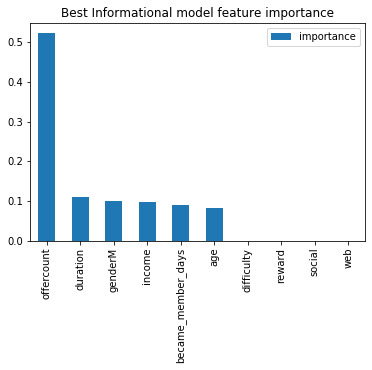

In [424]:
model=XGBClassifier(max_depth=3,min_samples_split=3,n_estimators=300)
model.fit(x_train,y_train)
feature_importances = pd.DataFrame(model.feature_importances_,
                                   index = ['age','genderM','income','became_member_days','offercount','duration','difficulty','reward','social','web'],
                                    columns=['importance']).sort_values('importance',ascending=False)
feature_importances.plot.bar()
plt.title('Best Informational model feature importance')
plt.show()

* Results shows feature importance ranking for Discoun model:
    1. the number of offer the customer received
    2. offer duration
    3. the gender of the customer
    4. the income of the customer
    5. how long the customer has been Starbucks members
    6. age of customer  

For the three offer types, the best models are all XG Boosting, for the offer type BOGO and Discount, the f1 score for XG Boosting model is also pretty high, for offer type Informational, the f1 score for responsive group is pretty high, for non-responsive group is pretty low

#### Potential all-in-one model

In [320]:
Matrix_All=pd.concat([Res_Bogo,NonRes_Bogo,Res_discount,NonRes_discount,Res_info,NonRes_info])
Matrix_All['social'].mean()
Matrix_All['web'].mean()
Matrix_All['mobile'].mean()
#remove email as it is always 1
Matrix_All['email'].mean()

1.0

In [321]:
gender_Dummyall=pd.get_dummies(Matrix_All['gender'],drop_first=True).rename(columns={'M':'genderM'})
offertype_Dummyall=pd.get_dummies(Matrix_All['offer_type'],drop_first=True).rename(columns={'discount':'offer_type_discount','informational':'offer_type_informational'})
Matrix_All=pd.concat([Matrix_All.drop(['email'],axis=1),gender_Dummyall,offertype_Dummyall],axis=1)
del Matrix_All['gender']
del  Matrix_All['offer_type']

In [322]:
X=Matrix_All[['age','genderM','income','became_member_days','offercount','duration','difficulty','reward','social','mobile','web','offer_type_discount']]
Y=Matrix_All[['response']]
transformer=MinMaxScaler().fit(Matrix_All[['age','income','response','genderM','became_member_days','offercount','duration','difficulty','reward','social','mobile','web','offer_type_discount']])
Norm_All=pd.DataFrame(transformer.transform(Matrix_All[['age','income','response','genderM','became_member_days','offercount','duration','difficulty','reward','social','mobile','web','offer_type_discount']]),columns=[['age','income','response','genderM','became_member_days','offercount','duration','difficulty','reward','social','mobile','web','offer_type_discount']])

In [323]:
Norm_All['response']=Norm_All['response'].astype(int)
X=Norm_All[['age','genderM','income','became_member_days','offercount','duration','difficulty','reward','social','mobile','web','offer_type_discount']]
Y=Norm_All[['response']]

Text(0, 0.5, 'Accuracy')

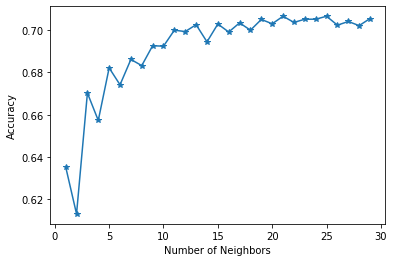

In [324]:
x_train,x_test,y_train,y_test=train_test_split(X,Y,test_size=0.2)
#first try KNN
import matplotlib.pyplot as plt
accuracy=[]
for i in range(1,30):
    knn=KNeighborsClassifier(n_neighbors=i)
    knn.fit(x_train,y_train)
    report = classification_report(y_test['response'],knn.predict(x_test), output_dict=True )
    accuracy.append(report['accuracy'])
plt.plot(range(1,30),accuracy,marker='*')
plt.xlabel('Number of Neighbors')
plt.ylabel('Accuracy')

In [325]:
# N=21 is the best number for N
knn=KNeighborsClassifier(n_neighbors=21)
knn.fit(x_train,y_train)
print(classification_report(y_test['response'],knn.predict(x_test)))
print(confusion_matrix(y_test['response'],knn.predict(x_test)))

              precision    recall  f1-score   support

           0       0.66      0.59      0.62      3806
           1       0.73      0.79      0.76      5441

    accuracy                           0.71      9247
   macro avg       0.70      0.69      0.69      9247
weighted avg       0.70      0.71      0.70      9247

[[2255 1551]
 [1162 4279]]


In [326]:
#try random forest
clf=RandomForestClassifier()
clf.fit(x_train,y_train)
print(classification_report(y_test['response'],clf.predict(x_test)))

              precision    recall  f1-score   support

           0       0.59      0.63      0.61      3806
           1       0.73      0.70      0.71      5441

    accuracy                           0.67      9247
   macro avg       0.66      0.67      0.66      9247
weighted avg       0.67      0.67      0.67      9247



In [328]:
#try XGboosting
xbg=XGBClassifier()
xbg.fit(x_train,y_train)
print(classification_report(y_test['response'],xbg.predict(x_test)))

              precision    recall  f1-score   support

           0       0.69      0.62      0.65      3806
           1       0.75      0.81      0.78      5441

    accuracy                           0.73      9247
   macro avg       0.72      0.71      0.72      9247
weighted avg       0.73      0.73      0.73      9247



* Model ranking based on accurary:
    1. XG Boosting accuracy is 0.73
    2. KNN accuracy is 0.71
    3. Random Forest accuracy is 0.67
* Results sugguest XG Boosting is the best model among the three, based on accuray

#### Refinement for all-in-one model

In [329]:
#Refine XG boosting using GridCV
parameter={'n_estimators':[300,1000,500],'max_depth':[3,6,10,15],'min_samples_split':[3,6,8,10]}
cv=GridSearchCV(xbg,parameter)
cv.fit(x_train,y_train)

[20:30:10] WARNING: C:\Users\Administrator\workspace\xgboost-win64_release_1.1.0\src\learner.cc:480: 
Parameters: { min_samples_split } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[20:30:13] WARNING: C:\Users\Administrator\workspace\xgboost-win64_release_1.1.0\src\learner.cc:480: 
Parameters: { min_samples_split } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[20:30:15] WARNING: C:\Users\Administrator\workspace\xgboost-win64_release_1.1.0\src\learner.cc:480: 
Parameters: { min_samples_split } might not be used.

  This may not be accurate due to some parameters are 

[20:31:38] WARNING: C:\Users\Administrator\workspace\xgboost-win64_release_1.1.0\src\learner.cc:480: 
Parameters: { min_samples_split } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[20:31:47] WARNING: C:\Users\Administrator\workspace\xgboost-win64_release_1.1.0\src\learner.cc:480: 
Parameters: { min_samples_split } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[20:31:54] WARNING: C:\Users\Administrator\workspace\xgboost-win64_release_1.1.0\src\learner.cc:480: 
Parameters: { min_samples_split } might not be used.

  This may not be accurate due to some parameters are 

[20:33:50] WARNING: C:\Users\Administrator\workspace\xgboost-win64_release_1.1.0\src\learner.cc:480: 
Parameters: { min_samples_split } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[20:33:56] WARNING: C:\Users\Administrator\workspace\xgboost-win64_release_1.1.0\src\learner.cc:480: 
Parameters: { min_samples_split } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[20:34:03] WARNING: C:\Users\Administrator\workspace\xgboost-win64_release_1.1.0\src\learner.cc:480: 
Parameters: { min_samples_split } might not be used.

  This may not be accurate due to some parameters are 

[20:36:36] WARNING: C:\Users\Administrator\workspace\xgboost-win64_release_1.1.0\src\learner.cc:480: 
Parameters: { min_samples_split } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[20:36:40] WARNING: C:\Users\Administrator\workspace\xgboost-win64_release_1.1.0\src\learner.cc:480: 
Parameters: { min_samples_split } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[20:36:44] WARNING: C:\Users\Administrator\workspace\xgboost-win64_release_1.1.0\src\learner.cc:480: 
Parameters: { min_samples_split } might not be used.

  This may not be accurate due to some parameters are 

[20:40:05] WARNING: C:\Users\Administrator\workspace\xgboost-win64_release_1.1.0\src\learner.cc:480: 
Parameters: { min_samples_split } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[20:40:26] WARNING: C:\Users\Administrator\workspace\xgboost-win64_release_1.1.0\src\learner.cc:480: 
Parameters: { min_samples_split } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[20:40:48] WARNING: C:\Users\Administrator\workspace\xgboost-win64_release_1.1.0\src\learner.cc:480: 
Parameters: { min_samples_split } might not be used.

  This may not be accurate due to some parameters are 

[20:45:02] WARNING: C:\Users\Administrator\workspace\xgboost-win64_release_1.1.0\src\learner.cc:480: 
Parameters: { min_samples_split } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[20:45:13] WARNING: C:\Users\Administrator\workspace\xgboost-win64_release_1.1.0\src\learner.cc:480: 
Parameters: { min_samples_split } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[20:45:24] WARNING: C:\Users\Administrator\workspace\xgboost-win64_release_1.1.0\src\learner.cc:480: 
Parameters: { min_samples_split } might not be used.

  This may not be accurate due to some parameters are 

[20:51:46] WARNING: C:\Users\Administrator\workspace\xgboost-win64_release_1.1.0\src\learner.cc:480: 
Parameters: { min_samples_split } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[20:51:55] WARNING: C:\Users\Administrator\workspace\xgboost-win64_release_1.1.0\src\learner.cc:480: 
Parameters: { min_samples_split } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[20:52:06] WARNING: C:\Users\Administrator\workspace\xgboost-win64_release_1.1.0\src\learner.cc:480: 
Parameters: { min_samples_split } might not be used.

  This may not be accurate due to some parameters are 

GridSearchCV(cv='warn', error_score='raise-deprecating',
             estimator=XGBClassifier(base_score=0.5, booster='gbtree',
                                     colsample_bylevel=1, colsample_bynode=1,
                                     colsample_bytree=1, gamma=0, gpu_id=-1,
                                     importance_type='gain',
                                     interaction_constraints='',
                                     learning_rate=0.300000012,
                                     max_delta_step=0, max_depth=6,
                                     min_child_weight=1, missing=nan,
                                     monotone_constraints='()',
                                     n...
                                     objective='binary:logistic',
                                     random_state=0, reg_alpha=0, reg_lambda=1,
                                     scale_pos_weight=1, subsample=1,
                                     tree_method='exact', validate_

In [330]:
print(classification_report(y_test['response'],cv.predict(x_test)))

              precision    recall  f1-score   support

           0       0.70      0.66      0.68      3806
           1       0.77      0.80      0.79      5441

    accuracy                           0.74      9247
   macro avg       0.73      0.73      0.73      9247
weighted avg       0.74      0.74      0.74      9247



In [405]:
pd.DataFrame({'BOGO XG Boosting Model':[0.74,0.74],'Discount XG Boosting Model':[0.75,0.75],'Informational XG Boosting Model':[0.93,0.90],'All-in-one Model':[0.74,0.74]},index=['accuracy','f1-score'])

,BOGO XG Boosting Model,Discount XG Boosting Model,Informational XG Boosting Model,All-in-one Model
accuracy,0.74,0.75,0.93,0.74
f1-score,0.74,0.75,0.90,0.74


The performance for all-in-one model is not better than three individual models, considering metrics accuracy and f1-score on testing dataset, will use the three individual XG Boosting models for the prediction

## Conclusion 

### Reflection

My final decision is to use 3 seperate models to predict whether a customer will be responsive to an offer, since the prediction accurary in the testing dataset is pretty good, BOGO model 0.74, Discount model 0.75 and Informational model 0.93.

The project is challenging for me in the aspect of feature engineering, on my first attempt the model was under fitting because I just considered the customer demographic information,age, gender and income. After adding in additional features, the model performance becomes better.

### Improvement

One improvement I would like to try is to impute the missing values in the customer profile dataset, for customer gender and income, probably we could impute them by looking at the customer behaviors, if the behaviors are similar, the gender and income might be similar as well. In this way, we will have more data, which will make model prediction more accurate